## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

### Wczytanie i analiza danych

In [2]:
# !kaggle datasets download -d andrewmvd/steam-reviews

In [3]:
# import zipfile
# with zipfile.ZipFile('steam-reviews.zip', 'r') as zip_ref:
#     zip_ref.extractall()

In [4]:
# Wyświetlenie całej zawartości kolumny
pd.set_option('display.max_colwidth', None)

# Wczytanie danych
reviews_df = pd.read_csv('data/dataset.csv')
reviews_df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,"This will be more of a ''my experience with this game'' type of review, because saying things like ''great gameplay'' will not suit something I've experienced with Counter-Strike. Here you go: I remember back in 2002 I was at a friend's house and he was playing a game. I didn't know the name of the game nor I had internet to find it. A few weeks passed by and another friend came over. He didn't have a computer, so he brought a disc with a game in it. He told me that it was one of the best games and from that very moment I knew that it is going to be the game I saw at the other friend's house. When I saw the Counter-Strike logo I was filled with gamegasm (?) and I was so happy. I was playing it hardcore. Made friends, clans, was involved in communities and even made two myself. Counter-Strike is my first game which I played competitively and it was a such an experience. Playing public servers with mods were very fun, but playing it competitively made it very intense and stressful. In a pleasant way, ofcourse. Looking at the current e-sport scene it might not seem like much but back then it was different. Shooters these days try to be different, advanced in a way. Sometimes the most simple games like Counter-Strike are the ones that live to this day. Also, there are plenty of mods to keep your attention to this game. The gameplay is very simple - defend as a Counter-Terrorist, attack as a Terrorist to plant the bomb or save the hostages as a CT. I am sure most of you already know this and I doubt there are gamers that haven't heard or know the gameplay of Counter-Strike, so I am sharing here more of my experience. I wish I could find my CS Anthology account which I've lost since 2008. So, I decided I am going to buy this game again and here you go - more than a thousand hours played. I still play it from time to time to this day and it brings back many great memories and I sometimes even stumble upon people I've played with years ago. I think Counter-Strike changed gaming in a major way and we wouldn't have many games like we have today, if this game wouldn't exist. I am sure many of people already have played games like CS:GO but never the roots. I doubt any of you will play it for more than an hour, because it's much more simple and it differs a lot in my opinion from CS:GO and modern games. It's harder though.",1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like games that don't lag? • Do you like games you can run on low end PC's? • Do you like games where you don't meet children who have slept with your mother? Then this is for you!,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [5]:
reviews_df['review_score'].value_counts()

review_score
 1    5260420
-1    1156686
Name: count, dtype: int64

Zmiana wartości klasy z *-1* na *0*

In [6]:
reviews_df['review_score'].replace(-1, 0, inplace=True)
reviews_df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,"This will be more of a ''my experience with this game'' type of review, because saying things like ''great gameplay'' will not suit something I've experienced with Counter-Strike. Here you go: I remember back in 2002 I was at a friend's house and he was playing a game. I didn't know the name of the game nor I had internet to find it. A few weeks passed by and another friend came over. He didn't have a computer, so he brought a disc with a game in it. He told me that it was one of the best games and from that very moment I knew that it is going to be the game I saw at the other friend's house. When I saw the Counter-Strike logo I was filled with gamegasm (?) and I was so happy. I was playing it hardcore. Made friends, clans, was involved in communities and even made two myself. Counter-Strike is my first game which I played competitively and it was a such an experience. Playing public servers with mods were very fun, but playing it competitively made it very intense and stressful. In a pleasant way, ofcourse. Looking at the current e-sport scene it might not seem like much but back then it was different. Shooters these days try to be different, advanced in a way. Sometimes the most simple games like Counter-Strike are the ones that live to this day. Also, there are plenty of mods to keep your attention to this game. The gameplay is very simple - defend as a Counter-Terrorist, attack as a Terrorist to plant the bomb or save the hostages as a CT. I am sure most of you already know this and I doubt there are gamers that haven't heard or know the gameplay of Counter-Strike, so I am sharing here more of my experience. I wish I could find my CS Anthology account which I've lost since 2008. So, I decided I am going to buy this game again and here you go - more than a thousand hours played. I still play it from time to time to this day and it brings back many great memories and I sometimes even stumble upon people I've played with years ago. I think Counter-Strike changed gaming in a major way and we wouldn't have many games like we have today, if this game wouldn't exist. I am sure many of people already have played games like CS:GO but never the roots. I doubt any of you will play it for more than an hour, because it's much more simple and it differs a lot in my opinion from CS:GO and modern games. It's harder though.",1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like games that don't lag? • Do you like games you can run on low end PC's? • Do you like games where you don't meet children who have slept with your mother? Then this is for you!,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [7]:
reviews_df[['app_name', 'review_text', 'review_score']].sample(20)

,app_name,review_text,review_score
5906524,Darksiders,"I originally bought and played this game on console, back when it first came out (2010), and bought this one with the 'Darksiders Franchise Pack' that was for $14.99 in May (2014). The game mechanics are pretty decent, although, jumping can feel awkward at times (especially when you get the Wings). Where this game really excels, is in the overall story, dialogue, and music. I can't wait to see if any other games in the series come out (Darksiders II feels the same as this one, but I haven't played much of it...yet).",1
3406592,Kane & Lynch 2: Dog Days,"Just like the first game very short, completed it in less then 4 hours. But despite that fact it was one cool rollercoaster ride! It's almost like playing a action movie!",1
1846576,The Swapper,"a very dramatic, clever and philosophical storyline. clever and fun puzzles. it also makes you think about existentialist concepts while playing, so it is worth your time.",1
3541215,METAL GEAR SOLID V: THE PHANTOM PAIN,"scrape your nutsack over extremely coarse concrete floor for an entire week and smash glass jars into your face until you pass out into a coma and you'll have a better time than you'll have in the multiplayer, as for the singleplayer i'm still waiting for the patch that finishes the story",0
5689973,Deer Man,"I was deeply touched by this game. I was left crying at my desk by this soft, yet emotional experience. I want to see more 'games' like this. This game is definitly for grown-ups, as it is mostly an emotional experience. I really respect those kind of games and I really want to see more of this kind of games.",1
5152940,Undertale,"This game is my new favorite thing like im really High-Key obsessed with it. The storyline is great, i love how at the end it all fits together perfectly. The sound track is unbelievably good, and the sans fight is awesome! It took me days!!! ***** Five Stars!",1
3813996,Robocraft,Early Access Review,1
4641223,Eron,"A Fun and precise game! You need good reflexes and a strong tolerance to faliure, otherwise you're screwed.",1
3413733,Ubersoldier II,"Are you familiar with the term 'so bad it's good'? Like something that is just objectively not well made but is still for some reason incredibly enjoyable? Ubersoldier II is like that. It is so bad, so utterly horrible, so poorly made that it should never be played... but for some reason I loved nearly every second of it. This game is the 'Sharknado' of video games. It is bad in nearly every aspect but still a fun romp. The voice acting is so bad, the story is almost completely nonsensical, the cutscenes are laughably awful. This being said, everytime there is any kind of story exposition I can't help but crack a smile and just enjoy it. The gunplay itself is pretty bland, not horrible but nothing amazing. You get some special powers that spice things up a little and are really fun the first few times you use them but pretty quickly get stale. The level design is so so so so bad that sometimes when I was playing through the game I would get stuck running around in circles while trying to complete a level and would end up screaming WHY????? when I finally figure out how to progress. But even navigating these bizarre levels was kind of fun in their own way. It was like exploring some kind of weird post modern work of art. Is this a good game? Hell no. Is this game worth playing? Hell yes. (maybe just get it when it's on sale)",1
4355196,Medieval Engineers,Early Access Review,1


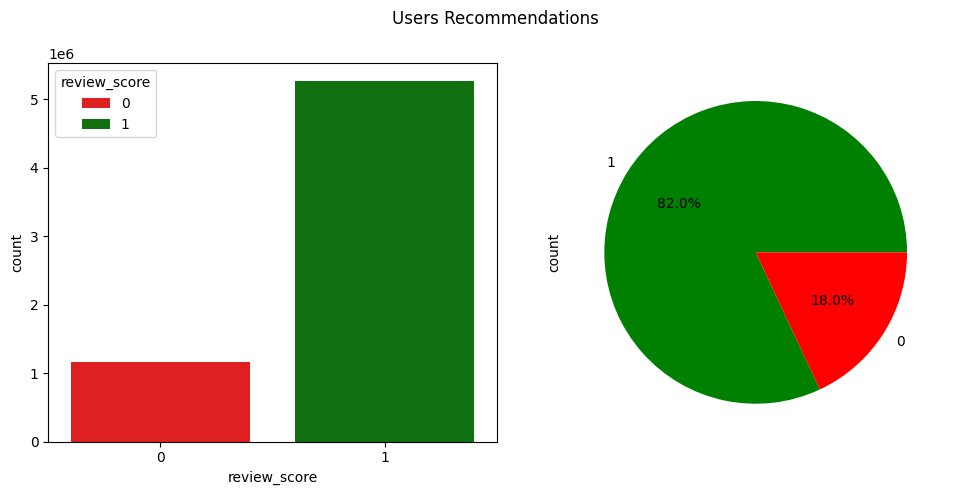

In [8]:
color_dict = {0: "red", 1: "green"}

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x='review_score', data=reviews_df, hue='review_score', palette=[color_dict[0], color_dict[1]], ax=axs[0])
reviews_df['review_score'].value_counts().plot.pie(autopct='%1.1f%%', colors=[color_dict[1], color_dict[0]], ax=axs[1])
fig.suptitle('Users Recommendations')
plt.tight_layout()

In [9]:
reviews_df['review_text'] = reviews_df['review_text'].str.strip()
reviews_df = reviews_df[(reviews_df['review_text'] != 'Early Access Review') & (reviews_df['review_votes'] != 0)]
reviews_df.reset_index(drop=True, inplace=True)
reviews_df.head()


,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"This will be more of a ''my experience with this game'' type of review, because saying things like ''great gameplay'' will not suit something I've experienced with Counter-Strike. Here you go: I remember back in 2002 I was at a friend's house and he was playing a game. I didn't know the name of the game nor I had internet to find it. A few weeks passed by and another friend came over. He didn't have a computer, so he brought a disc with a game in it. He told me that it was one of the best games and from that very moment I knew that it is going to be the game I saw at the other friend's house. When I saw the Counter-Strike logo I was filled with gamegasm (?) and I was so happy. I was playing it hardcore. Made friends, clans, was involved in communities and even made two myself. Counter-Strike is my first game which I played competitively and it was a such an experience. Playing public servers with mods were very fun, but playing it competitively made it very intense and stressful. In a pleasant way, ofcourse. Looking at the current e-sport scene it might not seem like much but back then it was different. Shooters these days try to be different, advanced in a way. Sometimes the most simple games like Counter-Strike are the ones that live to this day. Also, there are plenty of mods to keep your attention to this game. The gameplay is very simple - defend as a Counter-Terrorist, attack as a Terrorist to plant the bomb or save the hostages as a CT. I am sure most of you already know this and I doubt there are gamers that haven't heard or know the gameplay of Counter-Strike, so I am sharing here more of my experience. I wish I could find my CS Anthology account which I've lost since 2008. So, I decided I am going to buy this game again and here you go - more than a thousand hours played. I still play it from time to time to this day and it brings back many great memories and I sometimes even stumble upon people I've played with years ago. I think Counter-Strike changed gaming in a major way and we wouldn't have many games like we have today, if this game wouldn't exist. I am sure many of people already have played games like CS:GO but never the roots. I doubt any of you will play it for more than an hour, because it's much more simple and it differs a lot in my opinion from CS:GO and modern games. It's harder though.",1,1
1,10,Counter-Strike,"Easy to learn, hard to master.",1,1
2,10,Counter-Strike,"No r8 revolver, 10/10 will play again.",1,1
3,10,Counter-Strike,Still better than Call of Duty: Ghosts...,1,1
4,10,Counter-Strike,"cant buy skins, cases, keys, stickers - gaben cant steal our money 10/10 would play again",1,1


In [10]:
reviews_df['review_score'].value_counts()

review_score
1    545897
0    222160
Name: count, dtype: int64

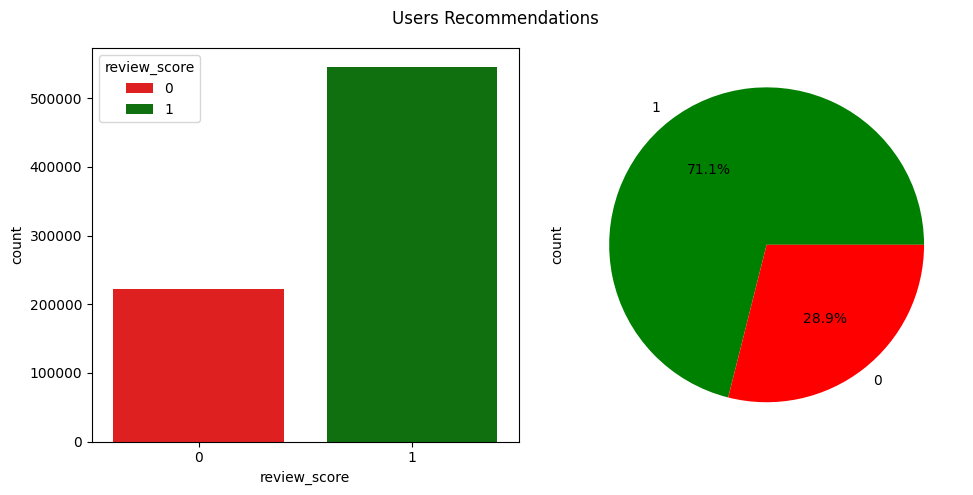

In [11]:
color_dict = {0: "red", 1: "green"}

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x='review_score', data=reviews_df, hue='review_score', palette=[color_dict[0], color_dict[1]], ax=axs[0])
reviews_df['review_score'].value_counts().plot.pie(autopct='%1.1f%%', colors=[color_dict[1], color_dict[0]], ax=axs[1])
fig.suptitle('Users Recommendations')
plt.tight_layout()

Po usunięciu tekstów z samym 'Early Access Review' oraz recenzji źle ocenionych przez pozostałych użytkowników (review_votes = 0) klasy dla wystawionych ocen wciąż są mocno niezbalansowane.

W związku z tym, że po wstępnej filtracji wciąż mamy bardzo dużo danych (ponad 750 000 rekordów), klasy zbalansujemy poprzez usunięcie losowych przykładów pozytywnych ocen tak, aby było ich tyle samo,
co recenzji negatywnych.

In [12]:
from sklearn.utils import resample

reviews_1 = reviews_df[reviews_df.review_score == 1]
reviews_0 = reviews_df[reviews_df.review_score == 0]

reviews_1_us = resample(reviews_1, 
                        replace=False, 
                        n_samples=len(reviews_0),
                        random_state=42)
 

reviews_df_balanced = pd.concat([reviews_1_us, reviews_0])

reviews_df_balanced['review_score'].value_counts()


review_score
1    222160
0    222160
Name: count, dtype: int64

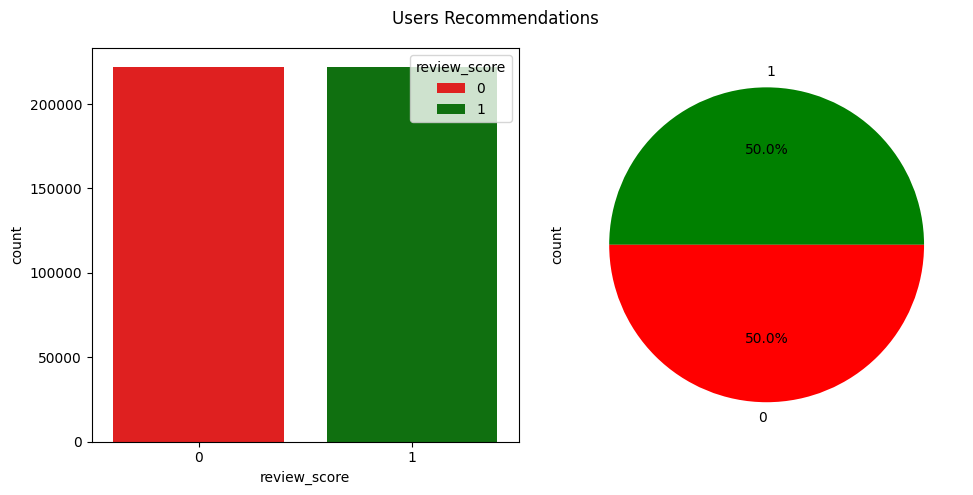

In [15]:
color_dict = {0: "red", 1: "green"}

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x='review_score', data=reviews_df_balanced, hue='review_score', palette=[color_dict[0], color_dict[1]], ax=axs[0])
reviews_df_balanced['review_score'].value_counts().plot.pie(autopct='%1.1f%%', colors=[color_dict[1], color_dict[0]], ax=axs[1])
fig.suptitle('Users Recommendations')
plt.tight_layout()

In [13]:
reviews_df_balanced.reset_index(drop=True, inplace=True)
reviews_df_balanced.head()

app_id             app_name  \
0  218620             PAYDAY 2   
1  248570             Toribash   
2  426790              Grow Up   
3  238460  BattleBlock Theater   
4  248820         Risk of Rain   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [16]:
df = reviews_df_balanced[['review_text', 'review_score']].reset_index(drop=True)
df.head()

review_text  \
0  This game is very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very

### Preprocessing

Usunięcie stopwords

In [17]:
# Downloading the english model
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     --------------------------------------- 0.0/42.8 MB 320.0 kB/s eta 0:02:14
     --------------------------------------- 0.1/42.8 MB 544.7 kB/s eta 0:01:19
     ---------------------------------------- 0.2/42.8 MB 1.3 MB/s eta 0:00:33
     ---------------------------------------- 0.4/42.8 MB 2.2 MB/s eta 0:00:20
      --------------------------------------- 0.7/42.8 MB 2.7 MB/s eta 0:00:16
      --------------------------------------- 0.9/42.8 MB 3.2 MB/s eta 0:00:13
     - -------------------------------------- 1.2/42.8 MB 3.6 MB/s eta 0:00:12
     - -------------------------------------- 1.3/42.8 MB 3.7 MB/s eta 0:00:12
     - -------------------------------------- 1.5/42.8 MB 3.7 MB/s eta 0:00:12
     - -------------------------------------- 1.9/42.8 MB 4.2 MB/s eta 0:00:10
     - -------------------------------------- 2.1/42.8 MB 4.2 MB/s eta 0:00:10
     -- ------------------------------------- 2.4/42.8 MB

In [18]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [19]:
def remove_stop_words(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

df['review_text'] = df['review_text'].astype(str).apply(remove_stop_words)
df.head()

,review_text,review_score
0,This game good,1
1,fight pro generic noob lunge thing shredded bits won~!,1
2,"Grow Up I wanted sequel Grow Home. The positives: + More collectibles + Challenges + More costumes + Huge world explore multiple biomes, new plants, animals + Mobility options built BUD instead plant based (i.e. Glider Air Break instead Flower Leaf) + Additional character POD, help find things map The negative: - BUD difficult handle challenges precise movements limited time Other negative, Ubisoft Reflections perfect sequel game proud work!",1
3,Hmmm... How this... A stupid game funny man making jokes telling story &amp; surprisingly addictive fun matter play co-op friends. 9/10,1
4,hard good (i like like that). #betterthannuclearthronexddd,1


Lowercase

In [20]:
df['review_text'] = df['review_text'].apply(lambda x: x.lower())
df.head()

,review_text,review_score
0,this game good,1
1,fight pro generic noob lunge thing shredded bits won~!,1
2,"grow up i wanted sequel grow home. the positives: + more collectibles + challenges + more costumes + huge world explore multiple biomes, new plants, animals + mobility options built bud instead plant based (i.e. glider air break instead flower leaf) + additional character pod, help find things map the negative: - bud difficult handle challenges precise movements limited time other negative, ubisoft reflections perfect sequel game proud work!",1
3,hmmm... how this... a stupid game funny man making jokes telling story &amp; surprisingly addictive fun matter play co-op friends. 9/10,1
4,hard good (i like like that). #betterthannuclearthronexddd,1


Usunięcie znaków specjalnych

In [21]:
df.loc[:, 'review_text'] = df['review_text'].str.replace(r"[^a-z\s']", '', regex=True)

df.head()

,review_text,review_score
0,this game good,1
1,fight pro generic noob lunge thing shredded bits won,1
2,grow up i wanted sequel grow home the positives more collectibles challenges more costumes huge world explore multiple biomes new plants animals mobility options built bud instead plant based ie glider air break instead flower leaf additional character pod help find things map the negative bud difficult handle challenges precise movements limited time other negative ubisoft reflections perfect sequel game proud work,1
3,hmmm how this a stupid game funny man making jokes telling story amp surprisingly addictive fun matter play coop friends,1
4,hard good i like like that betterthannuclearthronexddd,1


Lemmatyzacja

In [22]:
def lemmatize(text):
  return ' '.join(x.lemma_ for x in nlp(text))

# def tokenize_and_lemmatize(text):
#     doc = nlp(text)
#     return [token.lemma_ for token in doc]

# Apply the function to the column containing the text in your df dataset
df_lemmatized = df.copy()
df_lemmatized['review_text'] = df_lemmatized['review_text'].apply(lemmatize)

df_lemmatized.head()

,review_text,review_score
0,this game good,1
1,fight pro generic noob lunge thing shred bit win,1
2,grow up I want sequel grow home the positive more collectible challenge more costume huge world explore multiple biome new plant animal mobility option build bud instead plant base ie glider air break instead flower leaf additional character pod help find thing map the negative bud difficult handle challenge precise movement limited time other negative ubisoft reflection perfect sequel game proud work,1
3,hmmm how this a stupid game funny man make joke tell story amp surprisingly addictive fun matter play coop friend,1
4,hard good I like like that betterthannuclearthronexddd,1


### Przygotowanie danych do modeli

Train/val/test split

In [29]:
RANDOM_SEED = 42

X = df_lemmatized[['review_text']]
y = df_lemmatized['review_score']

# Pierwszy podział - wyodrębnienie zbioru trenigowego, pozostałe 30% danych będzie rozdzielone na zbiór walidacyjny i testowy
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

# Drugi podział - wyodrębnienie zbioru walidacyjnego (20%) i testowego (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=RANDOM_SEED, stratify=y_temp)


In [30]:
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (311024, 1), y_train shape: (311024,)
X_val shape: (88864, 1), y_val shape: (88864,)
X_test shape: (44432, 1), y_test shape: (44432,)


In [31]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data.head()

,review_text,review_score
94554,people play this,1
121851,if you be slightly interested arcade racing game andor football check outwell actually you be in rocket league you be play football or soccer car addition speed booster jump great move aerial shot you choose v v v v match it be near player real football that be actually good thing v pretty messy chaoticthen again fun it be easy game tutorial basic like handle booster aerial shot defense etc but do not mean challenge to insane aerial maneuver you will need train the main motivation come competitive game rank game normal match player there singleplayer mode that be practice get game selling point game you unlock stuff car like hat booster color tire pattern car I have big fan genre rocket league manage pull get excited match play even you be play random people it be bad fun have good team work good fun so hope field,1
112906,I go game low expectation have play final fantasy xiii hour give linear dungeon simply require a b kill monster process I pleasantly surprise find lightning return far superior experience overall to begin with world open fairly quickly let explore different hub area interact npc there vendor quest giver imbue character sense freedom sorely lack xiii the story focus take lightning journey save soul mankind world come end build simple premise add layer intrigue character lumina another positive quest tie story main give lightning undertake personal quest save soul learn little bit process nevertheless I would remiss I do not mention canvas prayer ' quest basically run collect material anonymous people since world come end make sense there be tick clock haunt step at glance undoubtedly come huge negative game provide mean stall clock variety way first gather soul collect call eradia add day clock furthermore ability ingame call chronostasis let freeze clock thirty ingame minute if you be doubtful start easy pretty forget clock on plus side passage time allow game hub area dynamic unlocking area vendor quest giver event specific time build illusion live breathing world you be in combat reprise xiii formula atb system enhance schemata schemata essentially build create comprise garb weapon accessory ability during battle switch different schematas atb bar give leeway deal variety enemy furthermore ability weapon upgrade game ng if help I find sink lot time game realize it what impress most personally grip story actually interesting relevant quest you do not need play previous game enjoy understand what be go game pretty good job lay background ironically lightning return be mind well entry point xiii be the end bit confusing I will that return kingesque feeling it I find immensely satisfying so want final fantasy general lightning trilogy particular lightning return shoot like I game look for,1
214549,unbelievably addicting infuriate challenging competitive insane amount hype playing friend I game month now I school time work I hour game it fill moment free time have cut beauty sleep the dog shorter walk food burn cook want smash face screen rip little ers throat garbage say intercom bestgameever rage again,1
415175,this can not happen I be totally serious thing borderline unplayable holy crap purpose absolutely work right the second nightmare zipple do not control like good platformer instead play like mythical d platformer tank control like bubsy d however it be bad here turn speed sound way change sensitivity absolutely way finesse job it be literally base luck manage point right direction it feel smooth gameplay trailer sort twist joke feel like idiot figure magic formula the objective thing bring useless crap house want collectathon control good freaking luck to defend forever respawne enemy zipple shoot incredible electric ball render useless poor aim you invincible run turn like tornado fun briefest moment lastly rock periodically fall head may kill enemy citation need actually try end zipple 's futile voyage randomly similar generate level eternity 

In [32]:
val_data = pd.concat([X_val, y_val], axis=1)
val_data.head()

,review_text,review_score
77632,I wish people know amazing game this game counter strike deserve more I wish steam advertise game home screen day people atention I like server fill this good game I ve play halflife engine rule you will not regret buying game,1
352411,normally I person convince people buy total war game friend steam know but now case I love game come out it way well twr but it be case can 's dlc strategy outrageous back napoleon tw tws dlcs actually good stuff here single dlc ridiculously similar another they twr again they relase dlcs month release lol I have not see like before,0
354395,I like anime d fighter inlcude scroll one phantom breaker worst there sure nice pixel art especially background character art different story game port xbox that be it nice art list issue big bear I it be advertise multiplayer yes play co op screen lol I dissapointe support online kof heck battle block theater online no tutorial whatsoever sort how to ' booklet ' read do not help unless practise move will not learn practise mode so steep learning curve begin normal mode require lot grind unlock special power set cool finisher I find die ton time second level boss simply I underpowered lack emphasis player skill game seriously promote spamming attack button lot thing happen screen time hard time thing correctly way enemy attack like stack boss therefore counter block basically happen randomly awful control scheme first take time h m l sp mean game will not tell your key binding add fact block happen nothing heck think good idea annoying ok let us live that but sp button frustrating you want counter son do you well press sp enemy attack land ya easy right wrong because sp button butt load function activate emergency mode drain hp tad ' too ' late will not counter activate emergency mode it happen lot of time can not stuff screen that frustrating thing ever combo ok executing throw bad half time do not work imput lag maybe seriously simple gt plus h near enemy yet it be fricke hard story non existent find press button time ' cutsey ' voice sooo annoying character bore cliche I play ninja girl I hope tough line instead ' moe ' whatever I be go to puke ayame tenchu that be ninja girl not wishy washy psychopath smile cute voice uguu because port sprite bit enlarged resolution option overall buy king fighter skull girl well time game well design control scheme way fun play frustrating candy cover piece horse manure,0
172825,come hard life,1
336006,can not run tired dns flush update driver port forwardingdisabling nvidea streaming service change setting repair game multiple time remove reinstall abode falsh for reason everything week old solid state drive run perfectly havnt crash game drive total war warhmmer mate issue log character computer load new area play hit new area boot login everytime would not log again occassionally let in play problem area need load like game can not recommend base experience ask refund,0


In [33]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data.head()

,review_text,review_score
9440,at it be good unlike unturned,1
147915,it be ok,1
387058,do buy game buck especially you be trackmania veteran it be run smoother prettier look general lack feature previous version console port likely it be ok game sequel trackmania,0
246128,this game stunk,0
13479,es gud gam pls pack,1


Tokenizacja

In [55]:
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def yield_tokens(data_iter):
  for text in data_iter:
    yield tokenizer(text)

In [48]:
train_iter = iter(list(train_data['review_text']))

In [54]:
len(list(train_data['review_text']))

311024

In [56]:
MAX_TOKENS = 25000

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>'], max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

In [58]:
vocab(['game', 'is', 'very', 'good'])

[1, 0, 271, 13]

In [59]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == '1' else 0

In [62]:
text_pipeline('This game is so bad')

[0, 1, 0, 64, 26]

DataLoader

In [60]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
  label_list, text_list, lenghts = [], [], []

  for _text, _label in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    lenghts.append(processed_text.size(0))

  label_list = torch.tensor(label_list, dtype=torch.float32)
  lenghts = torch.tensor(lenghts, dtype=torch.int64)
  text_list = pad_sequence(text_list, batch_first=True)
  return label_list, text_list, lenghts


In [61]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

### Modele

#### GRU

In [ ]:
# class GRUModel(nn.Module):
#     def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
#       super().__init__()
#       self.embedding = nn.Embedding(input_dim, embedding_dim)
#       self.rnn = nn.GRU(embedding_dim, 
#                         hidden_dim, 
#                         num_layers=n_layers, 
#                         bidirectional=bidirectional, 
#                         dropout=dropout)
            
#       self.fc = nn.Linear(hidden_dim, output_dim)
#       self.dropout = nn.Dropout(dropout)


#     def forward(self, text, text_lenght):
#       embedded = self.embedding(text)
#       packed_embedded = pack_padded_sequence(embedded, text_lenght.cpu(), batch_first=True, enforce_sorted=False)
#       packed_output, hidden = self.rnn(packed_embedded)
#       output, output_lenghts = pad_packed_sequence(packed_output, batch_first=True)
#       return self.fc(hidden.squeeze(0))